In [1]:
# Now that we've constructed our dataframes, complete with our climate, population,
# and economic data, we can look for correlations between these data and the mortality rate
# by constructing some models. I'll try linear regressions, random forests and neural
# networks.

# We'll also have the occasion to see if the counties' mortality rates are correlated with
# themselves by exploring Moran's I-statistic.

import numpy as np

In [2]:
import pandas as pd
ak = pd.read_csv('alaska_raw.csv')
fl = pd.read_csv('florida_raw.csv')

In [3]:
# Let's import some modeling tools.

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

# Alaskan Tuberculosis

In [4]:
# Let's first isolate our dependent variable.

y = ak['mx']

In [5]:
ak.columns

Index(['Unnamed: 0', 'location_name', 'sex', 'year_id', 'mx', 'lower', 'upper',
       'Climate', 'Population', 'Rank', 'Borough or Census Area',
       'Per capita income', 'Median household income', 'Median family income',
       'Number of households', 'Aleutians East Borough',
       'Aleutians West Census Area', 'Anchorage Municipality',
       'Bethel Census Area', 'Bristol Bay Borough', 'Denali Borough',
       'Dillingham Census Area', 'Fairbanks North Star Borough',
       'Haines Borough', 'Hoonah-Angoon Census Area',
       'Juneau City and Borough', 'Kenai Peninsula Borough',
       'Ketchikan Gateway Borough', 'Kodiak Island Borough',
       'Kusilvak Census Area', 'Lake and Peninsula Borough',
       'Matanuska-Susitna Borough', 'Nome Census Area', 'North Slope Borough',
       'Northwest Arctic Borough', 'Petersburg Borough',
       'Prince of Wales-Hyder Census Area', 'Sitka City and Borough',
       'Skagway Municipality', 'Southeast Fairbanks Census Area',
       'Val

In [6]:
ak = ak.drop(columns = ['Unnamed: 0', 'Borough or Census Area'])

In [7]:
ak.head()

,location_name,sex,year_id,mx,lower,upper,Climate,Population,Rank,Per capita income,...,Cold semi-arid/Dry-summer subarctic/Subarctic,Cold semi-arid/Subarctic,Dry-summer subarctic/Subarctic,Oceanic,Oceanic/Subarctic,Subarctic,Tundra/Cold semi-arid/Dry-summer subarctic/Subarctic,Tundra/Dry-summer subarctic/Subarctic,Tundra/Oceanic/Subarctic,Tundra/Subarctic
0,Aleutians East Borough,Male,1980,2.439332,0.880294,5.486764,Tundra/Oceanic/Subarctic,3360,22,"$22,279",...,0,0,0,0,0,0,0,0,1,0
1,Aleutians East Borough,Male,1981,2.216467,0.810367,4.925977,Tundra/Oceanic/Subarctic,3360,22,"$22,279",...,0,0,0,0,0,0,0,0,1,0
2,Aleutians East Borough,Male,1982,2.078669,0.793859,4.475446,Tundra/Oceanic/Subarctic,3360,22,"$22,279",...,0,0,0,0,0,0,0,0,1,0
3,Aleutians East Borough,Male,1983,1.959400,0.772705,4.326649,Tundra/Oceanic/Subarctic,3360,22,"$22,279",...,0,0,0,0,0,0,0,0,1,0
4,Aleutians East Borough,Male,1984,1.903574,0.771711,3.986682,Tundra/Oceanic/Subarctic,3360,22,"$22,279",...,0,0,0,0,0,0,0,0,1,0


In [7]:
# Let's be more specific about the 'Rank' column before we forget what it is!

ak = ak.rename({'Rank': 'Per_Cap_Inc_Rank'}, axis = 1)

In [8]:
# Many of the columns we just added contain strings rather than numerics, so let's
# change that now.

ak['Per capita income'] = ak['Per capita income'].map(lambda x: int(x.replace('$', '').replace(',', '')))

ak['Median household income'] = ak['Median household income'].map(lambda x: int(x.replace('$', '').replace(',', '')))

ak['Median family income'] = ak['Median family income'].map(lambda x: int(x.replace('$', '').replace(',', '')))

ak['Number of households'] = ak['Number of households'].map(lambda x: int(x.replace(',', '')))

In [9]:
# Let's make better use of the 'sex' column now by dummying it out.

sex_dums = pd.get_dummies(ak['sex'])
ak = pd.concat([ak, sex_dums], axis = 1)

ak = ak.drop(columns = ['sex'])

In [10]:
ak.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3045 entries, 0 to 3044
Data columns (total 54 columns):
location_name                                           3045 non-null object
year_id                                                 3045 non-null int64
mx                                                      3045 non-null float64
lower                                                   3045 non-null float64
upper                                                   3045 non-null float64
Climate                                                 3045 non-null object
Population                                              3045 non-null int64
Per_Cap_Inc_Rank                                        3045 non-null int64
Per capita income                                       3045 non-null int64
Median household income                                 3045 non-null int64
Median family income                                    3045 non-null int64
Number of households                             

In [11]:
# The 'lower' and 'upper' columns are just error estimates on the mortality rate, so it
# would be overfitting – cheating, really – to include those.

test_columns = [col for col in ak.columns if (col not in ['lower','upper', 'Climate',
                                                          'location_name', 'mx'])]
X = ak[test_columns]

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3045 entries, 0 to 3044
Data columns (total 49 columns):
year_id                                                 3045 non-null int64
Population                                              3045 non-null int64
Per_Cap_Inc_Rank                                        3045 non-null int64
Per capita income                                       3045 non-null int64
Median household income                                 3045 non-null int64
Median family income                                    3045 non-null int64
Number of households                                    3045 non-null int64
Aleutians East Borough                                  3045 non-null int64
Aleutians West Census Area                              3045 non-null int64
Anchorage Municipality                                  3045 non-null int64
Bethel Census Area                                      3045 non-null int64
Bristol Bay Borough                                     3

## Linear Regression

In [13]:
# Let's try a linear regression.

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [14]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [15]:
lr = LinearRegression().fit(X_train, y_train)

In [16]:
lr.score(X_test, y_test)

0.8075661815989752

In [17]:
lr.coef_

array([-9.42114274e-02,  8.69376872e-05, -8.80752758e-02, -2.36209056e-04,
        9.56780688e-05, -8.05211266e-05, -2.50162338e-04, -4.12406184e-01,
       -2.68160152e-01,  4.79664008e-01,  1.92799288e+00, -8.19529597e-01,
        1.84565618e+00, -1.65610543e-01, -4.36721449e-01,  1.12368126e-01,
       -1.04714852e+00,  3.74782492e-01,  7.53104942e-02,  5.33164223e-01,
       -4.51659375e-01,  1.72768113e+00, -7.62151742e-01, -1.60084892e+00,
        4.44507930e-01, -1.29547066e-01,  1.35978097e-01, -2.83127631e-01,
       -7.28216149e-01,  5.15893242e-01,  2.81343390e-01, -5.70636873e-01,
       -3.53674063e-01, -8.75680896e-01,  5.23756719e-01, -7.29797471e-02,
       -7.29797471e-02, -5.70636873e-01,  3.93711516e-01,  5.26811634e-02,
       -4.51659375e-01,  5.61160782e-01, -1.29547066e-01,  4.87803842e-02,
       -4.12406184e-01,  5.80895400e-01,  2.26613164e-02,  3.50528579e-02,
       -5.77141743e-02])

In [18]:
lr.predict(X_test).shape

(762,)

## Exploring Correlations

In [19]:
ak.corr()['mx'].nlargest(10)

mx                          1.000000
upper                       0.982067
lower                       0.976064
Kusilvak Census Area        0.480152
Per_Cap_Inc_Rank            0.477818
Bethel Census Area          0.324496
Nome Census Area            0.215446
Northwest Arctic Borough    0.191525
Subarctic                   0.147291
Dillingham Census Area      0.116542
Name: mx, dtype: float64

In [20]:
ak.corr()['mx'].nsmallest(10)

Per capita income                -0.523392
year_id                          -0.480541
Median family income             -0.427072
Median household income          -0.279020
Number of households             -0.164075
Population                       -0.149792
Valdez-Cordova Census Area       -0.143564
Matanuska-Susitna Borough        -0.136452
Kenai Peninsula Borough          -0.135232
Dry-summer subarctic/Subarctic   -0.135063
Name: mx, dtype: float64

Tuberculosis mortality rates are significantly higher in Kusilvak relative to other counties, and significantly higher for lower incomes. Let's look at where Kusilvak ranks in per capita income.

In [60]:
ak.loc[ak['location_name'] == 'Kusilvak Census Area', 'Per_Cap_Inc_Rank'][1470]

29

That's dead last.

In [141]:
ak.loc[(ak['location_name'] == 'Kusilvak Census Area') & (ak['year_id'] == 2014), ['Population', 'sex', 'mx']]

,Population,sex,mx
1504,8010,Male,2.811160
1539,8010,Female,2.799181
1574,8010,Both,2.874031


Nearly 3 deaths per 100,000 people in Kusilvak. Let's do some research on Kusilvak.

This article (https://www.npr.org/sections/health-shots/2012/05/17/152848752/alaska-targets-an-old-foe-tuberculosis) talks about how tuberculosis used to be the \#1 killer in Alaska half a century ago. It also mentions that small and isolated villages can be hard to reach. According to Wikipedia (https://en.wikipedia.org/wiki/Kusilvak_Census_Area,_Alaska#Demographics), Kusilvak is 93% Native American, with a population of only 8000.
GoogleMaps cannot find driving directions to Hooper Bay, AK (the largest city in the county) from Anchorage, AK (https://www.google.com/maps/dir/Anchorage,+AK/Hooper+Bay,+AK/@61.0791257,-166.938305,5z/data=!3m1!4b1!4m14!4m13!1m5!1m1!1s0x56c8917604b33f41:0x257dba5aa78468e3!2m2!1d-149.9002778!2d61.2180556!1m5!1m1!1s0x573cc2a168476ce5:0x6c94fdd4fee12f7b!2m2!1d-166.0966666!2d61.5311111!3e0). Probably the census area is reachable only via plane or dogsled.

## New Models

Now probably our model is a bit overfit, since our betas are huge and there's some redundancy in the columns. For example, we have both the per capita income and the per capita income rank. Also, we're really using too many rows, since our population and income data are relevant only for dates around 2010. So let's try dropping the rows from years before 2006. (That way we'll have a nine-year period with 2010 in the middle.)

In [21]:
indices = ak.loc[ak['year_id'] < 2006].index

In [277]:
ak2 = ak.drop(indices)

In [23]:
test_columns = [col for col in ak2.columns if (col not in ['location_name', 'lower', 'upper',
                                                          'Per_Cap_Inc_Rank', 'mx',
                                                          'Median household income',
                                                          'Median family income',
                                                          'Number of households', 'Climate'])]
X2 = ak2[test_columns]
y2 = ak2['mx']

## Linear Regression Revisited

In [28]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 42)

In [29]:
ss = StandardScaler()
X2_train_scaled = ss.fit_transform(X2_train)
X2_test_scaled = ss.transform(X2_test)

In [30]:
lr2 = LinearRegression().fit(X2_train, y2_train)

In [31]:
lr2.score(X2_test, y2_test)

0.9296828977615562

In [32]:
ak2.corr()['mx'].nlargest(10)

mx                          1.000000
upper                       0.989187
lower                       0.988686
Kusilvak Census Area        0.646784
Per_Cap_Inc_Rank            0.569663
Bethel Census Area          0.453325
Nome Census Area            0.258941
Northwest Arctic Borough    0.187692
Subarctic                   0.173938
Tundra/Subarctic            0.116370
Name: mx, dtype: float64

In [33]:
ak2.corr()['mx'].nsmallest(10)

Per capita income                 -0.638392
Median family income              -0.521634
Median household income           -0.353748
year_id                           -0.178917
Dry-summer subarctic/Subarctic    -0.163782
Number of households              -0.155752
Southeast Fairbanks Census Area   -0.155702
Cold semi-arid/Subarctic          -0.155702
Valdez-Cordova Census Area        -0.153736
Kenai Peninsula Borough           -0.145053
Name: mx, dtype: float64

## Random Forest

In [34]:
rf = RandomForestRegressor().fit(X2_train, y2_train)

In [35]:
rf.score(X2_test, y2_test)

0.9735093314480908

In [36]:
rf.feature_importances_

array([5.98395802e-02, 1.34082363e-01, 6.33240866e-01, 2.53780586e-05,
       1.59716797e-03, 2.01179780e-04, 0.00000000e+00, 3.05313465e-04,
       3.92275069e-04, 1.97187898e-02, 2.87780892e-04, 1.09681811e-03,
       5.23418772e-05, 8.37581861e-05, 2.18173616e-05, 3.83858282e-04,
       1.49930843e-04, 3.96431190e-02, 1.93409144e-04, 1.12270898e-05,
       1.02251017e-02, 1.05361579e-05, 4.50926614e-04, 3.51605058e-05,
       1.64901414e-04, 3.28624047e-03, 3.89379616e-04, 3.83256596e-04,
       6.69883893e-04, 1.32951612e-05, 1.63613577e-04, 4.93058894e-03,
       5.05803662e-03, 1.88938544e-03, 6.74704312e-04, 3.92364982e-03,
       4.08852297e-05, 1.52705365e-02, 1.04055285e-05, 1.27823548e-02,
       1.61761646e-05, 2.63603687e-02, 1.87767329e-03, 1.21068951e-02,
       7.93906982e-03])

## Neural Network

In [79]:
# Let's also use keras to train up a neural network and see what happens.

from keras.models import Sequential
from keras.layers import Dense

/Users/gadamico/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [80]:
X_train, X_test, y_train, y_test = train_test_split(X2, y2, random_state = 42)

ss = StandardScaler()
X_scaled = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [81]:
# The model below is the result of some tinkering, but the general idea was to start with an
# input layer with a number of neurons roughly half the number of counties in the state in
# question. 'Relu' seems the appropriate activation function here in general, whereas the
# output layer, since we're modeling a regression, needs none.

model = Sequential()
model.add(Dense(20, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(1)) # default: activation = None

In [82]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [83]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 16)

Train on 587 samples, validate on 196 samples
Epoch 1/30
587/587 [==============================] - 0s 771us/step - loss: 546940.3834 - val_loss: 1.5509
Epoch 2/30
587/587 [==============================] - 0s 117us/step - loss: 61937.2094 - val_loss: 1.5553
Epoch 3/30
587/587 [==============================] - 0s 124us/step - loss: 12087.1146 - val_loss: 1.5601
Epoch 4/30
587/587 [==============================] - 0s 111us/step - loss: 6136.2237 - val_loss: 1.5666
Epoch 5/30
587/587 [==============================] - 0s 99us/step - loss: 3845.5661 - val_loss: 1.5707
Epoch 6/30
587/587 [==============================] - 0s 102us/step - loss: 3160.3211 - val_loss: 1.5735
Epoch 7/30
587/587 [==============================] - 0s 121us/step - loss: 2365.1752 - val_loss: 1.5758
Epoch 8/30
587/587 [==============================] - 0s 118us/step - loss: 2029.6611 - val_loss: 1.5788
Epoch 9/30
587/587 [==============================] - 0s 115us/step - loss: 1742.2274 - val_loss: 1.5820
Epoch 

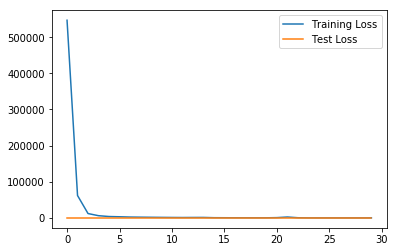

In [84]:
# Let's compare our training and test losses.

plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()

## Spatial Correlation

Let's test for spatial correlation among the counties with respect to our mortality rate.

In [50]:
# We'll need to know the mean mortality rate.

ak2['mx'].mean()

0.8960062955209891

In [37]:
# Let's group our data by location name to get a more streamlined look at the Alaskan
# counties.

ak2_boroughs = ak2.groupby('location_name').mean()
ak2_boroughs

,year_id,mx,lower,upper,Population,Per_Cap_Inc_Rank,Per capita income,Median household income,Median family income,Number of households,...,Oceanic,Oceanic/Subarctic,Subarctic,Tundra/Cold semi-arid/Dry-summer subarctic/Subarctic,Tundra/Dry-summer subarctic/Subarctic,Tundra/Oceanic/Subarctic,Tundra/Subarctic,Both,Female,Male
location_name,,,,,,,,,,,,,,,,,,,,,
Aleutians East Borough,2010,0.874231,0.423436,1.614015,3360,22,22279,54375,61250,553,...,0,0,0,0,0,1,0,0.333333,0.333333,0.333333
Aleutians West Census Area,2010,0.874231,0.423436,1.614015,5750,10,29920,72917,81875,1212,...,1,0,0,0,0,0,0,0.333333,0.333333,0.333333
Anchorage Municipality,2010,0.638626,0.443512,0.895622,301010,4,34678,73004,85023,107332,...,0,0,1,0,0,0,0,0.333333,0.333333,0.333333
Bethel Census Area,2010,2.777978,1.776847,4.091589,17868,27,18584,52214,55402,4651,...,0,0,0,0,1,0,0,0.333333,0.333333,0.333333
Bristol Bay Borough,2010,0.747949,0.246686,1.763773,957,5,31260,84000,92308,423,...,0,0,1,0,0,0,0,0.333333,0.333333,0.333333
Denali Borough,2010,0.793947,0.485441,1.233525,1921,1,42245,72500,81500,806,...,0,0,1,0,0,0,0,0.333333,0.333333,0.333333
Dillingham Census Area,2010,1.354956,0.770059,2.228150,4988,21,22597,60800,64113,1563,...,0,0,1,0,0,0,0,0.333333,0.333333,0.333333
Fairbanks North Star Borough,2010,0.415244,0.234509,0.682390,99357,8,30395,66598,79913,36441,...,0,0,1,0,0,0,0,0.333333,0.333333,0.333333
Haines Borough,2010,0.295952,0.117098,0.626739,2566,15,27979,47981,69821,1149,...,0,0,0,0,0,0,0,0.333333,0.333333,0.333333


In [38]:
ak2_boroughs = ak2_boroughs.reset_index()

Let's calculate Moran's I-Statistic by hand. According to wikipedia (https://en.wikipedia.org/wiki/Moran%27s_I),

$$
I = \frac{N}{W}\frac{\Sigma_i\Sigma_jw_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\Sigma_i(x_i - \bar{x})^2}
$$

$N$ is the number of regions we have, $W$ is the total of the entries of the matrix that describes the spatial relationships among the regions, and $w_{ij}$ are those entries themselves, i.e. the weights that characterize the spatial relationships.

We're just going to use the simple idea that bordering counties should get a weight value of 1 and other counties should get a weight of 0.

In [39]:
# We can calculate the denominator already.

((ak2_boroughs['mx'] - ak2_boroughs['mx'].mean()) ** 2).sum()

16.28823143762252

To calculate the numerator we'll need to take note of what borders what and of what the corresponding mortality rates are.

Borders:

Aleutians East: Lake and Peninsula

(0.874 - 0.896) * (1.355 - 0.896)

--

Aleutians West: NA

--

Anchorage: Kenai, Matanuska-Susitna, Valdez-Cordova

(0.639 - 0.896) * ((0.294 - 0.896) + (0.302 - 0.896) + (0.258 - 0.896))

--

Bethel: Dillingham, Kenai, Kusilvak, Lake and Peninsula, Matanuska-Susitna, Yukon-Koyukuk

(2.778 - 0.896) * ((1.355 - 0.896) + (0.294 - 0.896) + (3.581 - 0.896) + (1.355 - 0.896) + (0.302 - 0.896) + (0.794 - 0.896))

--

Bristol Bay: Dillingham, Lake and Peninsula

(0.748 - 0.896) * ((1.355 - 0.896) + (1.355 - 0.896))

--

Denali: Fairbanks North Star, Matanuska-Susitna, Southeast Fairbanks, Yukon-Koyukuk

(0.794 - 0.896) * ((0.415 - 0.896) + (0.302 - 0.896) + (0.25 - 0.896) + (0.794 - 0.896))

--

Dillingham: Bethel, Bristol Bay, Lake and Peninsula

(1.355 - 0.896) * (1.355 - 0.896)

--

Fairbanks North Star: Denali, Southeast Fairbanks, Yukon-Koyukuk

(0.415 - 0.896) * ((0.25 - 0.896) + (0.794 - 0.896))

--

Haines: Hoonah-Angoon, Juneau, Skagway

(0.296 - 0.896) * ((0.552 - 0896) + (0.619 - 0.896) + (0.552 - 0.896))

--

Hoonah-Angoon: Haines, Juneau, Petersburg, Sitka, Wrangell, Yakutat

(0.552 - 0.896) * ((0.619 - 0.896) + (0.541 - 0.896) + (0.926 - 0.896) + (0.541 - 0.896) + (0.552 - 0.896))

--

Juneau: Haines, Hoonah-Angoon

--

Kenai: Anchorage, Bethel, Kodiak, Lake and Peninsula, Matanuska-Susitna, Valdez-Cordova

(0.294 - 0.896) * ((0.479 - 0.896) + (1.355 - 0.896) + (0.302 - 0.896) + (0.258 - 0.896))

--

Ketchikan: Petersburg, Prince of Wales, Wrangell

(0.541 - 0.896) * ((0.541 - 0.896) + (0.541 - 0.896) + (0.541 - 0.896))

--

Kodiak: Kenai, Lake and Peninsula

(0.479 - 0.896) * (1.355 - 0.896)

--

Kusilvak: Bethel, Nome, Yukon-Koyukuk

(3.581 - 0.896) * (0.794 - 0.896)

--

Lake and Peninsula: Aleutians East, Bethel, Bristol Bay, Dillingham, Kenai, Kodiak

--

Matanuska-Susitna: Anchorage, Bethel, Denali, Kenai, Southeast Fairbanks, Valdez-Corodva, Yukon-Koyukuk

(0.302 - 0.896) * ((0.25 - 0.896) + (0.258 - 0.896) + (0.794 - 0.896))

--

Nome: Kusilvak, Northwest Arctic, Yukon-Koyukuk

(1.971 - 0.896) * ((1.675 - 0.896) + (0.794 - 0.896))

--

North Slope: Northwest Arctic, Yukon-Koyukuk

(0.888 - 0.896) * ((1.675 - 0.896) + (0.794 - 0.896))

--

Northwest Arctic: Nome, North Slope, Yukon-Koyukuk

(1.675 - 0.896) * (0.794 - 0.896)

--

Petersburg: Hoonah-Angoon, Ketchikan, Prince of Wales, Wrangell

(0.541 - 0.896) * ((0.541 - 0.896) + (0.541 - 0.896))

--

Prince of Wales: Ketchikan, Petersburg, Wrangell

(0.541 - 0.896) * (0.541 - 0.896)

--

Sitka: Hoonah-Angoon

--

Skagway: Haines

--

Southeast Fairbanks: Denali, Fairbanks North Star, Matanuska-Susitna, Valdez-Cordova, Yukon-Koyukuk

(0.25 - 0.896) * ((0.258 - 0.896) + (0.794 - 0.896))

--

Valdez-Cordova: Anchorage, Kenai, Matanuska-Susitna, Southeast Fairbanks, Yakutat

(0.258 - 0.896) * (0.552 - 0.896)

--

Wrangell: Hoonah-Angoon, Ketchikan, Petersburg, Prince of Wales

--

Yakutat: Hoonah-Angoon, Valdez-Cordova

--

Yukon-Koyukuk: Bethel, Denali, Fairbanks North Star, Kusilvak, Matanuska-Susitna, Nome, North Slope, Northwest Arctic, Southeast Fairbanks

--

N = 29 and W = 102.

After a massive calculation

(29 / (51 \* 16.288) \* ((0.874 - 0.896) \* (1.355 - 0.896) + (0.639 - 0.896) \* ((0.294 - 0.896) + (0.302 - 0.896) + (0.258 - 0.896)) + (2.778 - 0.896) \* ((1.355 - 0.896) + (0.294 - 0.896) + (3.581 - 0.896) + (1.355 - 0.896) + (0.302 - 0.896) + (0.794 - 0.896)) + (0.748 - 0.896) \* ((1.355 - 0.896) + (1.355 - 0.896)) + (0.794 - 0.896) \* ((0.415 - 0.896) + (0.302 - 0.896) + (0.25 - 0.896) + (0.794 - 0.896)) + (1.355 - 0.896) \* (1.355 - 0.896) + (0.415 - 0.896) \* ((0.25 - 0.896) + (0.794 - 0.896)) + (0.296 - 0.896) \* ((0.552 - 0.896) + (0.619 - 0.896) + (0.552 - 0.896)) + (0.552 - 0.896) \* ((0.619 - 0.896) + (0.541 - 0.896) + (0.926 - 0.896) + (0.541 - 0.896) + (0.552 - 0.896)) + (0.294 - 0.896) \* ((0.479 - 0.896) + (1.355 - 0.896) + (0.302 - 0.896) + (0.258 - 0.896)) + (0.541 - 0.896) \* ((0.541 - 0.896) + (0.541 - 0.896) + (0.541 - 0.896)) + (0.479 - 0.896) \* (1.355 - 0.896) + (3.581 - 0.896) \* (0.794 - 0.896) + (0.302 - 0.896) \* ((0.25 - 0.896) + (0.258 - 0.896) + (0.794 - 0.896)) + (1.971 - 0.896) \* ((1.675 - 0.896) + (0.794 - 0.896)) + (0.888 - 0.896) \* ((1.675 - 0.896) + (0.794 - 0.896)) + (1.675 - 0.896) \* (0.794 - 0.896) + (0.541 - 0.896) \* ((0.541 - 0.896) + (0.541 - 0.896)) + (0.541 - 0.896) \* (0.541 - 0.896) + (0.25 - 0.896) \* ((0.258 - 0.896) + (0.794 - 0.896)) + (0.258 - 0.896) \* (0.552 - 0.896)))

we find that I = 0.336.

This is in fact a significant result, since the expected value is only -1 / 28 = -0.036.

So we might try building neighbor-relationships into our model. Let's dummy on location_name _again_, this time with the intention of filling in the resulting columns according to _borders_.

In [278]:
ak2['location_name'] = ak2['location_name'].map(lambda x: x.replace(' ', ''))
border_dums = pd.get_dummies(ak2['location_name'])

In [279]:
ak2 = pd.concat([ak2, border_dums], axis = 1)

In [280]:
ak2.columns

Index(['location_name', 'year_id', 'mx', 'lower', 'upper', 'Climate',
       'Population', 'Per_Cap_Inc_Rank', 'Per capita income',
       'Median household income', 'Median family income',
       'Number of households', 'Aleutians East Borough',
       'Aleutians West Census Area', 'Anchorage Municipality',
       'Bethel Census Area', 'Bristol Bay Borough', 'Denali Borough',
       'Dillingham Census Area', 'Fairbanks North Star Borough',
       'Haines Borough', 'Hoonah-Angoon Census Area',
       'Juneau City and Borough', 'Kenai Peninsula Borough',
       'Ketchikan Gateway Borough', 'Kodiak Island Borough',
       'Kusilvak Census Area', 'Lake and Peninsula Borough',
       'Matanuska-Susitna Borough', 'Nome Census Area', 'North Slope Borough',
       'Northwest Arctic Borough', 'Petersburg Borough',
       'Prince of Wales-Hyder Census Area', 'Sitka City and Borough',
       'Skagway Municipality', 'Southeast Fairbanks Census Area',
       'Valdez-Cordova Census Area', 'Wrangell

In [281]:
# What follows is not exactly scalable (and I don't use it for states with more complex
# arrangements of (more numerous) counties). But the Alaskan case was relatively simple
# and so I filled in the values of the border matrix in this manual way.

# Roughly, I just went county by county, filling in the corresponding columns according to
# the bordering relationships we've just detailed.

def set_borders1(row):
    if row['location_name'] == 'LakeandPeninsulaBorough':
        return 1
    else:
        return 0

In [282]:
ak2['AleutiansEastBorough'] = ak2.apply(set_borders1, axis = 1)

In [289]:
ak2['AleutiansWestCensusArea'] = ak2['AleutiansWestCensusArea'].map(lambda x: 0)

In [293]:
def set_borders2(row):
    if (row['location_name'] == 'KenaiPeninsulaBorough') | (row['location_name'] == 'Matanuska-SusitnaBorough') | (row['location_name'] == 'Valdez-Cordova'):
        return 1
    else:
        return 0

In [295]:
ak2['AnchorageMunicipality'] = ak2.apply(set_borders2, axis = 1)

In [296]:
def set_borders3(row):
    if (row['location_name'] == 'DillinghamCensusArea') | (row['location_name'] == 'KenaiPeninsulaBorough') | (row['location_name'] == 'KusilvakCensusArea') | (row['location_name'] == 'LakeandPeninsulaBorough') | (row['location_name'] == 'Matanuska-SusitnaBorough') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [297]:
ak2['BethelCensusArea'] = ak2.apply(set_borders3, axis = 1)

In [300]:
def set_borders4(row):
    if (row['location_name'] == 'DillinghamCensusArea') | (row['location_name'] == 'LakeandPeninsulaBorough'):
        return 1
    else:
        return 0

In [301]:
ak2['BristolBayBorough'] = ak2.apply(set_borders4, axis = 1)

In [302]:
def set_borders5(row):
    if (row['location_name'] == 'FairbanksNorthStarBorough') | (row['location_name'] == 'Matanuska-SusitnaBorough') | (row['location_name'] == 'SoutheastFairbanksCensusArea') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [303]:
ak2['DenaliBorough'] = ak2.apply(set_borders5, axis = 1)

In [304]:
def set_borders6(row):
    if (row['location_name'] == 'BethelCensusArea') | (row['location_name'] == 'BristolBayBorough') | (row['location_name'] == 'LakeandPeninsulaBorough'):
        return 1
    else:
        return 0

In [305]:
ak2['DillinghamCensusArea'] = ak2.apply(set_borders6, axis = 1)

In [306]:
def set_borders7(row):
    if (row['location_name'] == 'DenaliBorough') | (row['location_name'] == 'SoutheastFairbanksCensusArea') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [307]:
ak2['FairbanksNorthStarBorough'] = ak2.apply(set_borders7, axis = 1)

In [308]:
def set_borders8(row):
    if (row['location_name'] == 'Hoonah-AngoonCensusArea') | (row['location_name'] == 'JuneauCityandBorough') | (row['location_name'] == 'SkagwayMunicipality'):
        return 1
    else:
        return 0

In [309]:
ak2['HainesBorough'] = ak2.apply(set_borders8, axis = 1)

In [311]:
def set_borders9(row):
    if (row['location_name'] == 'HainesBorough') | (row['location_name'] == 'JuneauCityandBorough') | (row['location_name'] == 'PetersburgBorough') | (row['location_name'] == 'SitkaCityandBorough') | (row['location_name'] == 'WrangellCItyandBorough') | (row['location_name'] == 'YakutatCityandBorough'):
        return 1
    else:
        return 0

In [312]:
ak2['Hoonah-AngoonCensusArea'] = ak2.apply(set_borders9, axis = 1)

In [313]:
def set_borders10(row):
    if (row['location_name'] == 'HainesBorough') | (row['location_name'] == 'Hoonah-AngoonCensusArea'):
        return 1
    else:
        return 0

In [314]:
ak2['JuneauCityandBorough'] = ak2.apply(set_borders10, axis = 1)

In [316]:
def set_borders11(row):
    if (row['location_name'] == 'AnchorageMunicipality') | (row['location_name'] == 'BethelCensusArea') | (row['location_name'] == 'KodiakIslandBorough') | (row['location_name'] == 'LakeandPeninsulaBorough') | (row['location_name'] == 'Matanuska-SusitnaBorough') | (row['location_name'] == 'Valdez-CordovaCensusArea'):
        return 1
    else:
        return 0

In [317]:
ak2['KenaiPeninsulaBorough'] = ak2.apply(set_borders11, axis = 1)

In [318]:
def set_borders12(row):
    if (row['location_name'] == 'PetersburgBorough') | (row['location_name'] == 'PrinceofWales-HyderCensusArea') | (row['location_name'] == 'WrangellCityandBorough'):
        return 1
    else:
        return 0

In [319]:
ak2['KetchikanGatewayBorough'] = ak2.apply(set_borders12, axis = 1)

In [320]:
def set_borders13(row):
    if (row['location_name'] == 'KenaiPeninsulaBorough') | (row['location_name'] == 'LakeandPeninsulaBorough'):
        return 1
    else:
        return 0

In [321]:
ak2['KodiakIslandBorough'] = ak2.apply(set_borders13, axis = 1)

In [322]:
def set_borders14(row):
    if (row['location_name'] == 'BethelCensusArea') | (row['location_name'] == 'NomeCensusArea') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [323]:
ak2['KusilvakCensusArea'] = ak2.apply(set_borders14, axis = 1)

In [324]:
def set_borders15(row):
    if (row['location_name'] == 'AleutiansEastBorough') | (row['location_name'] == 'BethelCensusArea') | (row['location_name'] == 'BristolBayBorough') | (row['location_name'] == 'DillinghamCensusArea') | (row['location_name'] == 'KenaiPeninsulaBorough') | (row['location_name'] == 'KodiakIslandBorough'):
        return 1
    else:
        return 0

In [325]:
ak2['LakeandPeninsulaBorough'] = ak2.apply(set_borders15, axis = 1)

In [326]:
def set_borders16(row):
    if (row['location_name'] == 'AnchorageMunicipality') | (row['location_name'] == 'BethelCensusArea') | (row['location_name'] == 'DenaliBorough') | (row['location_name'] == 'KenaiPeninsulaBorough') | (row['location_name'] == 'SoutheastFairbanksCensusArea') | (row['location_name'] == 'Valdez-CordovaCensusArea') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [327]:
ak2['Matanuska-SusitnaBorough'] = ak2.apply(set_borders16, axis = 1)

In [328]:
def set_borders17(row):
    if (row['location_name'] == 'KusilvakCensusArea') | (row['location_name'] == 'NorthwestArcticBorough') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [329]:
ak2['NomeCensusArea'] = ak2.apply(set_borders17, axis = 1)

In [330]:
def set_borders18(row):
    if (row['location_name'] == 'NorthwestArcticBorough') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [331]:
ak2['NorthSlopeBorough'] = ak2.apply(set_borders18, axis = 1)

In [332]:
def set_borders19(row):
    if (row['location_name'] == 'NomeCensusArea') | (row['location_name'] == 'NorthSlopeBorough') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [333]:
ak2['NorthwestArcticBorough'] = ak2.apply(set_borders19, axis = 1)

In [334]:
def set_borders20(row):
    if (row['location_name'] == 'Hoonah-AngoonCensusArea') | (row['location_name'] == 'KetchikanGatewayBorough') | (row['location_name'] == 'PrinceofWales-HyderCensusArea') | (row['location_name'] == 'WrangellCityandBorough'):
        return 1
    else:
        return 0

In [335]:
ak2['PetersburgBorough'] = ak2.apply(set_borders20, axis = 1)

In [336]:
def set_borders21(row):
    if (row['location_name'] == 'KetchikanGatewayBorough') | (row['location_name'] == 'PetersburgBorough') | (row['location_name'] == 'WrangellCityandBorough'):
        return 1
    else:
        return 0

In [337]:
ak2['PrinceofWales-HyderCensusArea'] = ak2.apply(set_borders21, axis = 1)

In [338]:
def set_borders22(row):
    if row['location_name'] == 'Hoonah-AngoonCensusArea':
        return 1
    else:
        return 0

In [339]:
ak2['SitkaCityandBorough'] = ak2.apply(set_borders22, axis = 1)

In [340]:
def set_borders23(row):
    if row['location_name'] == 'HainesBorough':
        return 1
    else:
        return 0

In [341]:
ak2['SkagwayMunicipality'] = ak2.apply(set_borders23, axis = 1)

In [342]:
def set_borders24(row):
    if (row['location_name'] == 'DenaliBorough') | (row['location_name'] == 'FairbanksNorthStarBorough') | (row['location_name'] == 'Matanuska-SusitnaBorough') | (row['location_name'] == 'Valdez-CordovaCensusArea') | (row['location_name'] == 'Yukon-KoyukukCensusArea'):
        return 1
    else:
        return 0

In [343]:
ak2['SoutheastFairbanksCensusArea'] = ak2.apply(set_borders24, axis = 1)

In [344]:
def set_borders25(row):
    if (row['location_name'] == 'AnchorageMunicipality') | (row['location_name'] == 'KenaiPeninsulaBorough') | (row['location_name'] == 'Matanuska-SusitnaBorough') | (row['location_name'] == 'SoutheastFairbanksCensusArea') | (row['location_name'] == 'YakutatCityandBorough'):
        return 1
    else:
        return 0

In [345]:
ak2['Valdez-CordovaCensusArea'] = ak2.apply(set_borders25, axis = 1)

In [346]:
def set_borders26(row):
    if (row['location_name'] == 'Hoonah-AngoonCensusArea') | (row['location_name'] == 'KetchikanGatewayBorough') | (row['location_name'] == 'PetersburgBorough') | (row['location_name'] == 'PrinceofWales-HyderCensusArea'):
        return 1
    else:
        return 0

In [347]:
ak2['WrangellCityandBorough'] = ak2.apply(set_borders26, axis = 1)

In [348]:
def set_borders27(row):
    if (row['location_name'] == 'Hoonah-AngoonCensusArea') | (row['location_name'] == 'Valdez-CordovaCensusArea'):
        return 1
    else:
        return 0

In [349]:
ak2['YakutatCityandBorough'] = ak2.apply(set_borders27, axis = 1)

In [351]:
def set_borders28(row):
    if (row['location_name'] == 'BethelCensusArea') | (row['location_name'] == 'DenaliBorough') | (row['location_name'] == 'FairbanksNorthStarBorough') | (row['location_name'] == 'KusilvakCensusArea') | (row['location_name'] == 'Matanuska-SusitnaBorough') | (row['location_name'] == 'NomeCensusArea') | (row['location_name'] == 'NorthSlopeBorough') | (row['location_name'] == 'NorthwestArcticBorough') | (row['location_name'] == 'SoutheastFairbanksCensusArea'):
        return 1
    else:
        return 0

In [352]:
ak2['Yukon-KoyukukCensusArea'] = ak2.apply(set_borders28, axis = 1)

Let's first try a model with ONLY these new border columns.

In [353]:
spatial_cols = ['AleutiansEastBorough', 'AleutiansWestCensusArea', 'AnchorageMunicipality',
                'BethelCensusArea', 'BristolBayBorough', 'DenaliBorough',
                'DillinghamCensusArea', 'FairbanksNorthStarBorough', 'HainesBorough',
                'Hoonah-AngoonCensusArea', 'JuneauCityandBorough', 'KenaiPeninsulaBorough',
                'KetchikanGatewayBorough', 'KodiakIslandBorough', 'KusilvakCensusArea',
                'LakeandPeninsulaBorough', 'Matanuska-SusitnaBorough', 'NomeCensusArea',
                'NorthSlopeBorough', 'NorthwestArcticBorough', 'PetersburgBorough',
                'PrinceofWales-HyderCensusArea', 'SitkaCityandBorough', 'SkagwayMunicipality',
                'SoutheastFairbanksCensusArea', 'Valdez-CordovaCensusArea',
                'WrangellCityandBorough', 'YakutatCityandBorough', 'Yukon-KoyukukCensusArea']
X3 = ak2[spatial_cols]
y3 = ak2['mx']

## Linear Regression Again

In [354]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, random_state = 42)

In [356]:
ss = StandardScaler()
X3_train_scaled = ss.fit_transform(X3_train)
X3_test_scaled = ss.transform(X3_test)

In [357]:
lr = LinearRegression()
lr.fit(X3_train_scaled, y3_train)
lr.score(X3_test_scaled, y3_test)

0.8907618874291245

Not bad! Let's see if we can do even better when we include more columns.

In [358]:
test_columns = [col for col in ak2.columns if (col not in ['location_name', 'lower', 'upper',
                                                          'Per_Cap_Inc_Rank', 'mx',
                                                          'Median household income',
                                                          'Median family income',
                                                          'Number of households', 'Climate'])]
X4 = ak2[test_columns]
y4 = ak2['mx']

In [359]:
X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, random_state = 42)

In [360]:
ss = StandardScaler()
X4_train_scaled = ss.fit_transform(X4_train)
X4_test_scaled = ss.transform(X4_test)

In [361]:
lr = LinearRegression()
lr.fit(X4_train_scaled, y4_train)
lr.score(X4_test_scaled, y4_test)

0.9297089318682671

# Floridian HIV / AIDS

In [4]:
# Much of this will follow the pattern we just set up for Alaskan tuberculosis.

y = fl['mx']

In [5]:
fl.columns

Index(['Unnamed: 0', 'location_name', 'sex', 'year_id', 'mx', 'lower', 'upper',
       'Climate', 'Rank_x', 'County_x', 'Population', 'Rank_y', 'County_y',
       'Per capita income', 'Median household income', 'Median family income',
       'Number of households', 'Alachua', 'Baker', 'Bay', 'Bradford',
       'Brevard', 'Broward', 'Calhoun', 'Charlotte', 'Citrus', 'Clay',
       'Collier', 'Columbia', 'DeSoto', 'Dixie', 'Duval', 'Escambia',
       'Flagler', 'Franklin', 'Gadsden', 'Gilchrist', 'Glades', 'Gulf',
       'Hamilton', 'Hardee', 'Hendry', 'Hernando', 'Highlands', 'Hillsborough',
       'Holmes', 'IndianRiver', 'Jackson', 'Jefferson', 'Lafayette', 'Lake',
       'Lee', 'Leon', 'Levy', 'Liberty', 'Madison', 'Manatee', 'Marion',
       'Martin', 'Miami-Dade', 'Monroe', 'Nassau', 'Okaloosa', 'Okeechobee',
       'Orange', 'Osceola', 'PalmBeach', 'Pasco', 'Pinellas', 'Polk', 'Putnam',
       'SantaRosa', 'Sarasota', 'Seminole', 'St.Johns', 'St.Lucie', 'Sumter',
       'Suwannee'

In [6]:
fl = fl.drop(columns = ['Unnamed: 0', 'County_x', 'County_y'])

In [86]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7035 entries, 0 to 7034
Data columns (total 86 columns):
location_name                        7035 non-null object
sex                                  7035 non-null object
year_id                              7035 non-null int64
mx                                   7035 non-null float64
lower                                7035 non-null float64
upper                                7035 non-null float64
Climate                              7035 non-null object
Rank_x                               7035 non-null int64
Population                           7035 non-null object
Rank_y                               7035 non-null int64
Per capita income                    7035 non-null object
Median household income              7035 non-null object
Median family income                 7035 non-null object
Number of households                 7035 non-null object
Alachua                              7035 non-null int64
Baker                   

In [87]:
fl.head()

,location_name,sex,year_id,mx,lower,upper,Climate,Rank_x,Population,Rank_y,...,Union,Volusia,Wakulla,Walton,Washington,Humid subtropical,Monsoon,Monsoon/Savanna/Humid subtropical,Rainforest/Monsoon/Savanna,Savanna
0,Alachua,Male,1980,0.000000,0.000000,0.000000,Humid subtropical,23,"266,944",28,...,0,0,0,0,0,1,0,0,0,0
1,Alachua,Male,1981,0.138703,0.100918,0.187205,Humid subtropical,23,"266,944",28,...,0,0,0,0,0,1,0,0,0,0
2,Alachua,Male,1982,0.232760,0.175992,0.304735,Humid subtropical,23,"266,944",28,...,0,0,0,0,0,1,0,0,0,0
3,Alachua,Male,1983,0.604388,0.476343,0.756813,Humid subtropical,23,"266,944",28,...,0,0,0,0,0,1,0,0,0,0
4,Alachua,Male,1984,1.332036,1.097646,1.597479,Humid subtropical,23,"266,944",28,...,0,0,0,0,0,1,0,0,0,0


In [7]:
fl = fl.rename({'Rank_x': 'Pop_Rank', 'Rank_y': 'Per_Cap_Inc_Rank'}, axis = 1)

In [8]:
fl['Per capita income'] = fl['Per capita income'].map(lambda x: int(x.replace('$', '').replace(',', '')))

fl['Median household income'] = fl['Median household income'].map(lambda x: int(x.replace('$', '').replace(',', '')))

fl['Median family income'] = fl['Median family income'].map(lambda x: int(x.replace('$', '').replace(',', '')))

fl['Number of households'] = fl['Number of households'].map(lambda x: int(x.replace(',', '')))

In [9]:
sex_dums = pd.get_dummies(fl['sex'])
fl = pd.concat([fl, sex_dums], axis = 1)

fl = fl.drop(columns = ['sex'])

In [10]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7035 entries, 0 to 7034
Data columns (total 88 columns):
location_name                        7035 non-null object
year_id                              7035 non-null int64
mx                                   7035 non-null float64
lower                                7035 non-null float64
upper                                7035 non-null float64
Climate                              7035 non-null object
Pop_Rank                             7035 non-null int64
Population                           7035 non-null object
Per_Cap_Inc_Rank                     7035 non-null int64
Per capita income                    7035 non-null int64
Median household income              7035 non-null int64
Median family income                 7035 non-null int64
Number of households                 7035 non-null int64
Alachua                              7035 non-null int64
Baker                                7035 non-null int64
Bay                          

In [11]:
fl['Population'] = fl['Population'].map(lambda x: int(x.replace(',', '')))

In [12]:
indices = fl.loc[fl['year_id'] < 2006].index
fl2 = fl.drop(indices)

In [13]:
test_columns = [col for col in fl2.columns if (col not in ['location_name', 'lower', 'upper',
                                                           'mx', 'Climate'])]
X = fl2[test_columns]
y = fl2['mx']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

## Linear Regression

In [17]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

In [18]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
lr.score(X_test_scaled, y_test)

0.43027065417817184

This is the only bad score I got from linear regression.

## Random Forest

In [19]:
rf = RandomForestRegressor().fit(X_train, y_train)

rf.score(X_test, y_test)

0.9775813627869472

## Exploring Correlations

In [15]:
fl.corr()['mx'].nlargest(10)

mx                      1.000000
upper                   0.999059
lower                   0.998980
Union                   0.564942
Male                    0.222875
Population              0.152050
Number of households    0.148893
Miami-Dade              0.121470
Monsoon                 0.121470
Broward                 0.088835
Name: mx, dtype: float64

In [104]:
fl.corr()['mx'].nsmallest(10)

Female              -0.233465
Humid subtropical   -0.143922
Per capita income   -0.047419
Okaloosa            -0.043219
Clay                -0.040231
Calhoun             -0.039840
SantaRosa           -0.039511
Walton              -0.038903
Gulf                -0.038434
Liberty             -0.038200
Name: mx, dtype: float64

The most significant fact here is that HIV/AIDS mortality is significantly positively correlated with Union County. Let's explore Union County.

In [115]:
fl.loc[(fl['Union'] == 1) & (fl['year_id'] == 2014), ['Pop_Rank', 'Male', 'Female', 'mx']]

,Pop_Rank,Male,Female,mx
6544,60,1,0,93.332130
6579,60,0,1,3.689365
6614,60,0,0,64.871216


Part of the reason these numbers are so high (nearly 1 in 1000 men!) is that, as this website (https://wtfflorida.com/news/the-state/union-county-leads-country-aids-melanoma-deaths/) points out, there is a big prison hospital in Union County. Also, Union County has a very small population otherwise.

But this website (http://www.jacksonville.com/opinion/editorials/2016-02-25/story/florida-must-do-more-address-soaring-rates-hiv-infections) assures us that, _in general_, the numbers for HIV are still unusually high in Florida as a whole. The article points out that rates are particularly high in the African-American population, while calling out Duval County (where Jacksonville) in particular.

In [114]:
fl.loc[(fl['Duval'] == 1) & (fl['year_id'] == 2014), ['Pop_Rank', 'Male', 'Female', 'mx']]

,Pop_Rank,Male,Female,mx
1504,7,1,0,9.326152
1539,7,0,1,4.841579
1574,7,0,0,6.952642


One in 10000 men is still high, especially for such a populous county, and Duval doesn't have the prison hospital excuse.

## Neural Network

In [116]:
ss = StandardScaler()
X_scaled = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [137]:
model = Sequential()
model.add(Dense(40, activation = 'relu', input_dim = X_train.shape[1]))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(5, activation = 'relu'))
model.add(Dense(1)) # default: activation = None

In [138]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [139]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 16)

Train on 1356 samples, validate on 453 samples
Epoch 1/30
1356/1356 [==============================] - 1s 438us/step - loss: 27089.1140 - val_loss: 65.6974
Epoch 2/30
1356/1356 [==============================] - 0s 120us/step - loss: 101.5098 - val_loss: 65.6650
Epoch 3/30
1356/1356 [==============================] - 0s 136us/step - loss: 99.8205 - val_loss: 65.6058
Epoch 4/30
1356/1356 [==============================] - 0s 128us/step - loss: 99.8158 - val_loss: 65.5225
Epoch 5/30
1356/1356 [==============================] - 0s 125us/step - loss: 99.8654 - val_loss: 65.4312
Epoch 6/30
1356/1356 [==============================] - 0s 144us/step - loss: 99.9964 - val_loss: 65.3268
Epoch 7/30
1356/1356 [==============================] - 0s 136us/step - loss: 99.6696 - val_loss: 65.2123
Epoch 8/30
1356/1356 [==============================] - 0s 128us/step - loss: 99.8144 - val_loss: 65.0851
Epoch 9/30
1356/1356 [==============================] - 0s 127us/step - loss: 99.6330 - val_loss: 64.

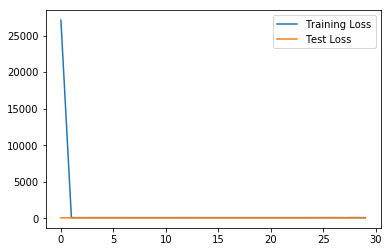

In [140]:
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Test Loss')
plt.legend()

## Spatial Correlation

In [233]:
# I found a .csv file online (https://www.census.gov/geo/reference/county-adjacency.html) that
# lists all the bordering counties for every county in the nation.

counties = pd.read_csv('county_adjacency2010.csv')

In [234]:
counties.head()

,countyname,fipscounty,neighborname,fipsneighbor
0,"Autauga County, AL",1001,"Autauga County, AL",1001
1,"Autauga County, AL",1001,"Chilton County, AL",1021
2,"Autauga County, AL",1001,"Dallas County, AL",1047
3,"Autauga County, AL",1001,"Elmore County, AL",1051
4,"Autauga County, AL",1001,"Lowndes County, AL",1085


In [235]:
# Let's split 'countyname' into 'county' and 'state'.

counties['county'], counties['state'] = counties['countyname'].str.split(',', 1).str

The above trick courtesy of https://stackoverflow.com/questions/14745022/how-to-split-a-column-into-two-columns.

In [236]:
counties.head()

,countyname,fipscounty,neighborname,fipsneighbor,county,state
0,"Autauga County, AL",1001,"Autauga County, AL",1001,Autauga County,AL
1,"Autauga County, AL",1001,"Chilton County, AL",1021,Autauga County,AL
2,"Autauga County, AL",1001,"Dallas County, AL",1047,Autauga County,AL
3,"Autauga County, AL",1001,"Elmore County, AL",1051,Autauga County,AL
4,"Autauga County, AL",1001,"Lowndes County, AL",1085,Autauga County,AL


That split leaves a ' ' before the actual name of the state in the 'state' column. So, before we get confused:

In [237]:
counties['state'] = counties['state'].map(lambda x: x.replace(' ', ''))

Now let's focus on Florida.

In [238]:
counties = counties.loc[counties['state'] == 'FL', :]

In [239]:
# Let's take note of where our index begins.

counties.head(1)

,countyname,fipscounty,neighborname,fipsneighbor,county,state
2146,"Alachua County, FL",12001,"Alachua County, FL",12001,Alachua County,FL


This list includes bordering counties from other states!

In [240]:
counties[counties['countyname'] == 'Escambia County, FL']

,countyname,fipscounty,neighborname,fipsneighbor,county,state
2243,"Escambia County, FL",12033,"Baldwin County, AL",1003,Escambia County,FL
2244,"Escambia County, FL",12033,"Escambia County, AL",1053,Escambia County,FL
2245,"Escambia County, FL",12033,"Escambia County, FL",12033,Escambia County,FL
2246,"Escambia County, FL",12033,"Santa Rosa County, FL",12113,Escambia County,FL


So let's remove those.

In [241]:
# This 'for'-loop checks for 'AL' and 'GA' in the 'neighborname' column (since Alabama
# and Georgia are the two states that Florida borders).

indices = []
for i in range(2146, 2146 + counties.shape[0]):
    if ('AL' in counties['neighborname'][i]) | ('GA' in counties['neighborname'][i]):
        indices.append(i)

In [242]:
counties = counties.drop(indices)

In [243]:
# We're going to have to play with the names a bit before  merging our new counties file with
# our Florida data frame fl2.

fl2['county'] = fl2['location_name'].map(lambda x: x + ' County')

In [244]:
# The plan is to dummy out the 'neighborname' column, which will put '1's in the right places.
# There is a slight problem, however, which is that there will be only one '1' per row. But
# we can address this by using the 'groupby()' method together with 'sum()'. This will put
# each county on a single row with all of the '1' together on that row for the bordering
# counties.

border_dums = pd.get_dummies(counties['neighborname'])

counties_dums = pd.concat([counties, border_dums], axis = 1)

counties_grouped = counties_dums.groupby('countyname').sum().reset_index()

For some strange reason this list has each county bordering itself. Let's change that.

In [247]:
for i in range(counties_grouped.shape[0]):
    counties_grouped.iloc[i, i + 3] = 0

In [248]:
counties_grouped

,countyname,fipscounty,fipsneighbor,"Alachua County, FL","Baker County, FL","Bay County, FL","Bradford County, FL","Brevard County, FL","Broward County, FL","Calhoun County, FL",...,"St. Johns County, FL","St. Lucie County, FL","Sumter County, FL","Suwannee County, FL","Taylor County, FL","Union County, FL","Volusia County, FL","Wakulla County, FL","Walton County, FL","Washington County, FL"
0,"Alachua County, FL",96008,96462,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,"Baker County, FL",84021,84297,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,"Bay County, FL",72030,72390,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,"Bradford County, FL",72042,72262,1,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,"Brevard County, FL",72054,72506,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,"Broward County, FL",60055,60268,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,"Calhoun County, FL",72078,72242,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,"Charlotte County, FL",84105,84377,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,"Citrus County, FL",60085,60347,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,"Clay County, FL",72114,72276,0,1,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [261]:
# Getting rid of unneeded columns and adjusting the 'countyname' column.

counties_merger = counties_grouped.drop(columns = ['fipscounty', 'fipsneighbor'])

counties_merger['countyname'] = counties_merger['countyname'].map(lambda x: x.replace(', FL',
                                                                                      ''))

counties_merger = counties_merger.rename({'countyname': 'county'}, axis = 1)

In [267]:
counties_merger

,county,"Alachua County, FL","Baker County, FL","Bay County, FL","Bradford County, FL","Brevard County, FL","Broward County, FL","Calhoun County, FL","Charlotte County, FL","Citrus County, FL",...,"St. Johns County, FL","St. Lucie County, FL","Sumter County, FL","Suwannee County, FL","Taylor County, FL","Union County, FL","Volusia County, FL","Wakulla County, FL","Walton County, FL","Washington County, FL"
0,Alachua County,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Baker County,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,Bay County,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,1
3,Bradford County,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,Brevard County,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
5,Broward County,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Calhoun County,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Charlotte County,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Citrus County,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
9,Clay County,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [356]:
# We're finally prepared to merge the counties data frame with our Florida HIV data frame.

fl2_total = fl2.merge(counties_merger, how = 'left', on = 'county')

In [357]:
fl2_total

,location_name,year_id,mx,lower,upper,Climate,Pop_Rank,Population,Per_Cap_Inc_Rank,Per capita income,...,"St. Johns County, FL","St. Lucie County, FL","Sumter County, FL","Suwannee County, FL","Taylor County, FL","Union County, FL","Volusia County, FL","Wakulla County, FL","Walton County, FL","Washington County, FL"
0,Alachua,2006,8.906997,7.700307,10.170607,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,Alachua,2007,7.634945,6.558243,8.844001,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,Alachua,2008,8.000284,6.884024,9.233454,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,Alachua,2009,7.629773,6.572421,8.761964,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,Alachua,2010,7.322917,6.225688,8.461637,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,Alachua,2011,5.855945,4.895961,6.929866,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,Alachua,2012,6.161754,5.275064,7.225342,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,Alachua,2013,6.217597,5.204866,7.302597,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
8,Alachua,2014,6.242243,5.251223,7.339791,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,Alachua,2006,4.194088,3.420877,5.089128,Humid subtropical,23,266944,28,24741,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [358]:
# Grouping the new data frame by location.

fl2_boroughs = fl2_total.groupby('location_name').mean()
fl2_boroughs = fl2_boroughs.reset_index()

In order to calculate Moran's I-statistic, we'll need the following:

In [359]:
fl2_boroughs['dev'] = fl2_boroughs['mx'] - fl2_boroughs['mx'].mean()

In [360]:
# We're going to have to tinker with the county names again, and so I'll use – God help
# me – regex.

import re

In [361]:
# The problem is counties with two names. I'll break this up into two: counties with a '.'
# at the end of the first name and counties without.

period_cties = []
for i in range(fl2_boroughs.shape[0]):
    if len(re.findall('\.[A-Z]', fl2_boroughs['location_name'][i])) != 0:
        period_cties.append(fl2_boroughs['location_name'][i])

In [362]:
period_cties

['St.Johns', 'St.Lucie']

In [363]:
two_word_cties = []
for i in range(fl2_boroughs.shape[0]):
    if len(re.findall('[a-z][A-Z]', fl2_boroughs['location_name'][i])) != 0:
        two_word_cties.append(fl2_boroughs['location_name'][i])

In [364]:
two_word_cties

['DeSoto', 'IndianRiver', 'PalmBeach', 'SantaRosa']

In [365]:
fl2_boroughs = fl2_boroughs.replace('St.Johns', 'St. Johns')
fl2_boroughs = fl2_boroughs.replace('St.Lucie', 'St. Lucie')
fl2_boroughs = fl2_boroughs.replace('IndianRiver', 'Indian River')
fl2_boroughs = fl2_boroughs.replace('PalmBeach', 'Palm Beach')
fl2_boroughs = fl2_boroughs.replace('SantaRosa', 'Santa Rosa')

Once again, the formula for Moran's I-statistic was:

$$
I = \frac{N}{W}\frac{\Sigma_i\Sigma_jw_{ij}(x_i - \bar{x})(x_j - \bar{x})}{\Sigma_i(x_i - \bar{x})^2}
$$

N, W, $\bar{x}$, and the denominator are pretty straightforward:

In [390]:
# N is the number of counties.
N = fl2_boroughs.shape[0]

In [403]:
# W is twice the number of borders.
W = counties_merger.drop(columns = ['county']).values.sum()

In [366]:
x_bar = fl2_boroughs['mx'].mean()

In [367]:
denom = ((fl2_boroughs['mx'] - fl2_boroughs['mx'].mean()) ** 2).sum()

The numerator, on the other hand, is more complicated. What we need is a nested loop: We need to loop through each county, adding on the product of that county's mortality rate with that of _every other_ county that borders it, i.e. every other county that has a 1 in the matrix we've tacked onto the end of our data frame.

N.B.: There is likely a more efficient way to do this, but I'm not overly concerned with performance issues since none of my states has a particularly large number of counties. Probably we'd need four figures before there would be issues.

In [388]:
num = 0
for i in range(fl2_boroughs.shape[0]):
    for county in fl2_boroughs['location_name']:
        if float(fl2_boroughs.loc[fl2_boroughs.index == i, county + ' County, FL']) == 1:
            num += float(fl2_boroughs.loc[fl2_boroughs['location_name'] == county, 'dev']) * float(fl2_boroughs.loc[fl2_boroughs.index == i, 'dev'])

In [389]:
num

230.29876022371212

We're finally ready to make our calculation of I:

In [404]:
(N / W) * (num / denom)

0.014842844254978789

Probably not significant, so I'll leave the matter here.